In [ ]:
!pip install --user tabulate

In [72]:
from sklearn.metrics import mean_squared_error,auc, roc_curve, classification_report
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
tqdm.pandas()
import seaborn as sns
import numpy as np
%matplotlib inline

In [13]:
h2o.init()
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\wdz\AppData\Local\Temp\tmp09y7js44
  JVM stdout: C:\Users\wdz\AppData\Local\Temp\tmp09y7js44\h2o_wdz_started_from_python.out
  JVM stderr: C:\Users\wdz\AppData\Local\Temp\tmp09y7js44\h2o_wdz_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,09 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_wdz_jtbjhq
H2O cluster total nodes:,1
H2O cluster free memory:,1.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


H2O cluster uptime:,09 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_wdz_jtbjhq
H2O cluster total nodes:,1
H2O cluster free memory:,1.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [10]:
import h2o
from h2o import H2OFrame

In [2]:
data = pd.read_csv('./default of credit card clients.csv',parse_dates =True, header=1, index_col = 0)

In [3]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
def age_convert(num): #age min 21, age max 79
    if 21>= num and num <40:
        return 0
    elif 40>= num and num <60:
        return 1 
    else:
        return 2

In [5]:
data['AGE'] = data['AGE'].progress_apply(age_convert)

In [54]:
categorical_features = ['SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default payment next month']

In [55]:
num_features = [x for x in data.columns.tolist() if x not in categorical_features]

In [56]:
from sklearn import preprocessing

num_values = data.loc[:int(len(data)*0.8)][num_features].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(num_values)
data.loc[:int(len(data)*0.8)][num_features] = pd.DataFrame(x_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [57]:
def df_to_h2oF(data, factor_list):
    
    h2o_df = H2OFrame(data)
    h2o_df[factor_list] = h2o_df[factor_list].asfactor()
    
    return h2o_df

In [58]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [59]:
train_h2o = df_to_h2oF(train, categorical_features)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [60]:
test_h2o = df_to_h2oF(test, categorical_features)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [61]:
from h2o.estimators import H2ORandomForestEstimator

model_rf = H2ORandomForestEstimator(ntrees=50, max_depth=10, nfolds=5,balance_classes=True)

In [62]:
model_rf.train(x=train_h2o.names[:-1],y=train_h2o.names[-1],training_frame=train_h2o)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [63]:
test_cat = categorical_features[:-1]

In [65]:
predict = model_rf.predict(df_to_h2oF(test.iloc[:,:-1],test_cat))

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [66]:
predict.head()

predict,p0,p1
1,0.446732,0.553268
0,0.854078,0.145922
0,0.902219,0.0977809
1,0.588423,0.411577
0,0.871565,0.128435
0,0.898128,0.101872
0,0.8771,0.1229
0,0.90191,0.0980901
0,0.861666,0.138334
1,0.758377,0.241623


In [67]:
def model_eval(model,train, test):
    train_true = train.as_data_frame()['default payment next month'].values
    test_true = test.as_data_frame()['default payment next month'].values
    train_pred = model.predict(train).as_data_frame()['p1'].values
    test_pred = model.predict(test).as_data_frame()['p1'].values

    train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
    test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
    train_auc = np.round(auc(train_fpr, train_tpr), 5)
    test_auc = np.round(auc(test_fpr, test_tpr), 5)

    print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(float)))

    train_fpr = np.insert(train_fpr, 0, 0)
    train_tpr = np.insert(train_tpr, 0, 0)
    test_fpr = np.insert(test_fpr, 0, 0)
    test_tpr = np.insert(test_tpr, 0, 0)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
    ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
    ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=12)
    #plt.savefig(name+''+'output.jpg' )
    plt.show()


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      4734
           1       0.72      0.29      0.41      1266

   micro avg       0.83      0.83      0.83      6000
   macro avg       0.78      0.63      0.66      6000
weighted avg       0.81      0.83      0.80      6000



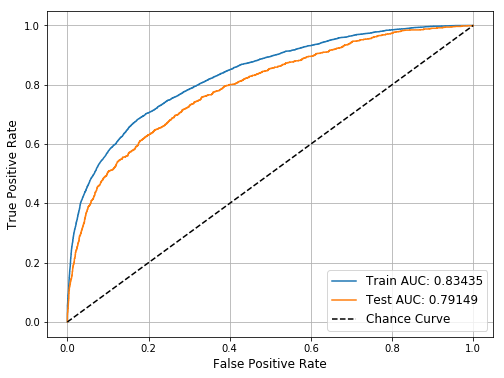

In [70]:
model_eval(model_rf, train_h2o, test_h2o)

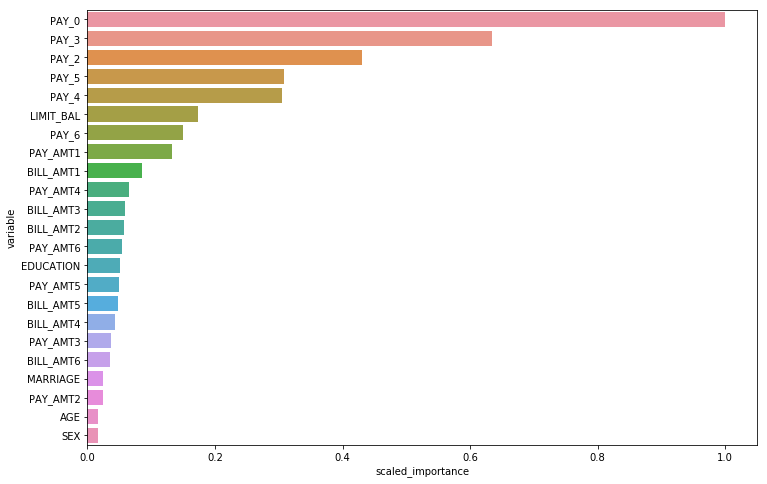

In [73]:
importance = model_rf.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(x='scaled_importance', y='variable', data=importance)
#plt.savefig('importances.jpg')
plt.show()